### Sobre o Autor

- **Aluno**: João Guilherme Squinelato de Melo
- **Repositório**: 

### Bibliotecas

In [1]:
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Lendo dados sobre clima

In [2]:
column_names = [
    'date',
    'hour',
    'total_precipitation',
    'atm_preassure_at_station',
    'max_atm_pressure_previous_hour',
    'min_atm_pressure_previous_hour',
    'global_radiation',
    'dry_bulb_air_temperature',
    'dew_point_air_temperature',
    'max_temperature_previous_hour',
    'min_temperature_previous_hour',
    'max_dew_point_air_temperature_previous_hour',
    'min_dew_point_air_temperature_previous_hour',
    'max_relative_air_humidity_previous_hour',
    'min_relative_air_humidity_previous_hour',
    'relative_air_humidity',
    'wind_direction',
    'max_wind_gust',
    'wind_speed',
    'region',
    'state',
    'station',
    'station_code',
    'latitude',
    'longitude',
    'height'
]

south_weather = pd.read_csv(
    filepath_or_buffer='./data/weather/south.csv', # caminho do arquivo csv
    sep=',', # indica que arquivo separa valores por vergula
    index_col=0, # lê primeira coluna como index do dataframe
    quotechar='"', # indica que valores estão contidos entre aspas
    decimal='.', # determina que números decimais são representados por ponto '.'
    header=0, # ignora cabeçalho original
    names=column_names, # renomeia colunas
    chunksize=10000, # lê o arquivo paulatinamente da memória física em porções de 10 mil registro
    date_format='%Y-%m-%d', # especifica o que os valores de date estão no padrão YYYY-MM-DD
    parse_dates=[0], # converte coluna para tipo date
)

In [3]:
south_weather_chunk = south_weather.get_chunk()

In [4]:
south_weather_chunk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 7575
Data columns (total 26 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   date                                         10000 non-null  datetime64[ns]
 1   hour                                         10000 non-null  object        
 2   total_precipitation                          10000 non-null  float64       
 3   atm_preassure_at_station                     10000 non-null  float64       
 4   max_atm_pressure_previous_hour               10000 non-null  float64       
 5   min_atm_pressure_previous_hour               10000 non-null  float64       
 6   global_radiation                             10000 non-null  int64         
 7   dry_bulb_air_temperature                     10000 non-null  float64       
 8   dew_point_air_temperature                    10000 non-null  float64       
 9   m

In [6]:
south_weather_chunk.sample(5)

,date,hour,total_precipitation,atm_preassure_at_station,max_atm_pressure_previous_hour,min_atm_pressure_previous_hour,global_radiation,dry_bulb_air_temperature,dew_point_air_temperature,max_temperature_previous_hour,...,wind_direction,max_wind_gust,wind_speed,region,state,station,station_code,latitude,longitude,height
3734,2001-01-07,14:00,0.0,1001.7,1001.7,1001.4,2929,32.1,19.0,32.2,...,304,8.9,3.9,S,RS,PORTO ALEGRE,A801,-30.050000,-51.166667,46.97
6353,2001-04-26,17:00,0.2,1009.8,1010.6,1009.8,592,20.4,18.9,20.8,...,292,3.8,1.2,S,RS,PORTO ALEGRE,A801,-30.050000,-51.166667,46.97
1275,2001-12-18,03:00,0.0,950.9,951.0,950.8,-9999,21.0,9.6,21.0,...,140,2.5,0.7,S,RS,SANTO AUGUSTO,A805,-27.854167,-53.791111,490.00
6711,2001-05-11,15:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,S,RS,PORTO ALEGRE,A801,-30.050000,-51.166667,46.97
1318,2001-12-19,22:00,0.0,952.6,952.6,952.3,398,30.5,14.0,32.2,...,179,4.4,2.9,S,RS,SANTO AUGUSTO,A805,-27.854167,-53.791111,490.00


### 1) Pré-Processamento de Dados - Tratamento de Valores Ausentes e Inválidos

**Questão**: Considerando que alguns valores ausentes no dataset podem ser substituídos em vez de descartados, quais seriam as possíveis estratégias para substituir valores ausentes e valores inválidos (como -9999)? Implemente ao menos uma estratégia de substituição e compare os resultados com a remoção dos dados.

**Objetivo**: Entender o impacto de diferentes abordagens de tratamento de dados ausentes no dataset

#### Transformando dados para responder à pergunta

In [7]:
missing_values = ~south_weather_chunk.isin([-9999, -9999.0])
south_weather_chunk_na = south_weather_chunk.where(missing_values, pd.NA)

In [8]:
south_weather_chunk_na.dropna(
    axis='index', # eliminar as linhas que satisfizeram as condições de valores faltantes
    thresh=21, # determina que para uma linhas ser mantida, esta devem possuir 21 valores não nulos (se 30% das colunas numéricas foram nulas, esta linha é eliminada)
    inplace=True
)

In [9]:
south_weather_chunk_numeric = south_weather_chunk_na.select_dtypes(include=['float64'])
numeric_columns = south_weather_chunk_numeric.columns

In [10]:
south_weather_chunk_numeric.reset_index(drop=True, inplace=True)

In [11]:
knn_imputer = KNNImputer(n_neighbors=3, weights='distance', metric='nan_euclidean')

In [12]:
knn_imputer.fit(south_weather_chunk_numeric)

KNNImputer(n_neighbors=3, weights='distance')

In [13]:
south_weather_chunk_filled = knn_imputer.transform(south_weather_chunk_numeric)

In [14]:
south_weather_chunk_imputation = pd.DataFrame(data=south_weather_chunk_filled, columns=numeric_columns)

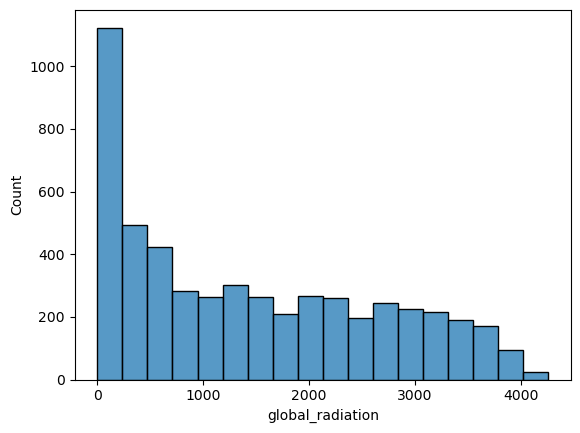

In [15]:
sns.histplot(data=south_weather_chunk_numeric, x="global_radiation")
plt.show()

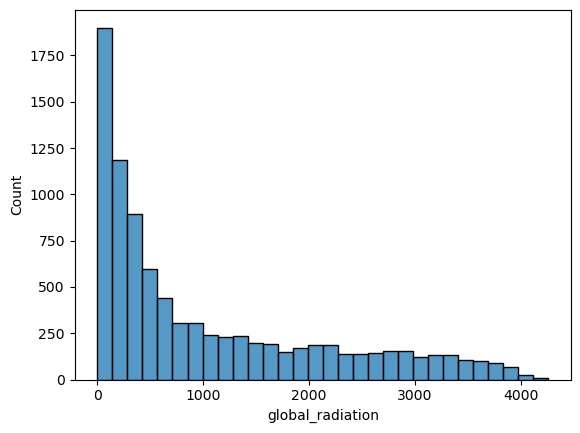

In [16]:
sns.histplot(data=south_weather_chunk_imputation, x="global_radiation")
plt.show()

#### Resposta

Para tratar valores faltantes, poderíamos: removê-los, perdendo informações valiosas; inserir valores substitutos com base em estatísticas de localidade, como média, mediana e moda; utilizar métodos que considerem

Tomando como exemplo da coluna _global_radiation_, que contém diversos valores faltantes, vê se que seus valores representam, a grosso modo, uma distribuição exponencial.\
Contudo, ao preenchermos valores falantes por meio do método de _KNN Imputer_, percebe-se maior assemelhança a uma distribuiçao exponencial.

### 2) Análise de Correlação - Seleção de Atributos

**Questão**: Ao analisar a correlação entre variáveis numéricas e a variável-alvo VENTO, VELOCIDADE HORARIA (m/s), quais atributos apresentam a correlação mais alta? Como essa seleção de atributos poderia influenciar a construção de um modelo preditivo? Justifique a escolha dos atributos a serem mantidos.

**Objetivo**: Identificar os atributos que têm maior influência sobre a variável de interesse, e compreender como a correlação pode ajudar a reduzir a dimensionalidade do problema, mantendo apenas variáveis relevantes.

#### Transformando dados para responder à pergunta

In [17]:
south_weather_metrics = south_weather_chunk_imputation.drop(columns=['latitude', 'longitude', 'height'])

In [18]:
south_weather_metrics_corr = south_weather_metrics.corr(method='spearman')

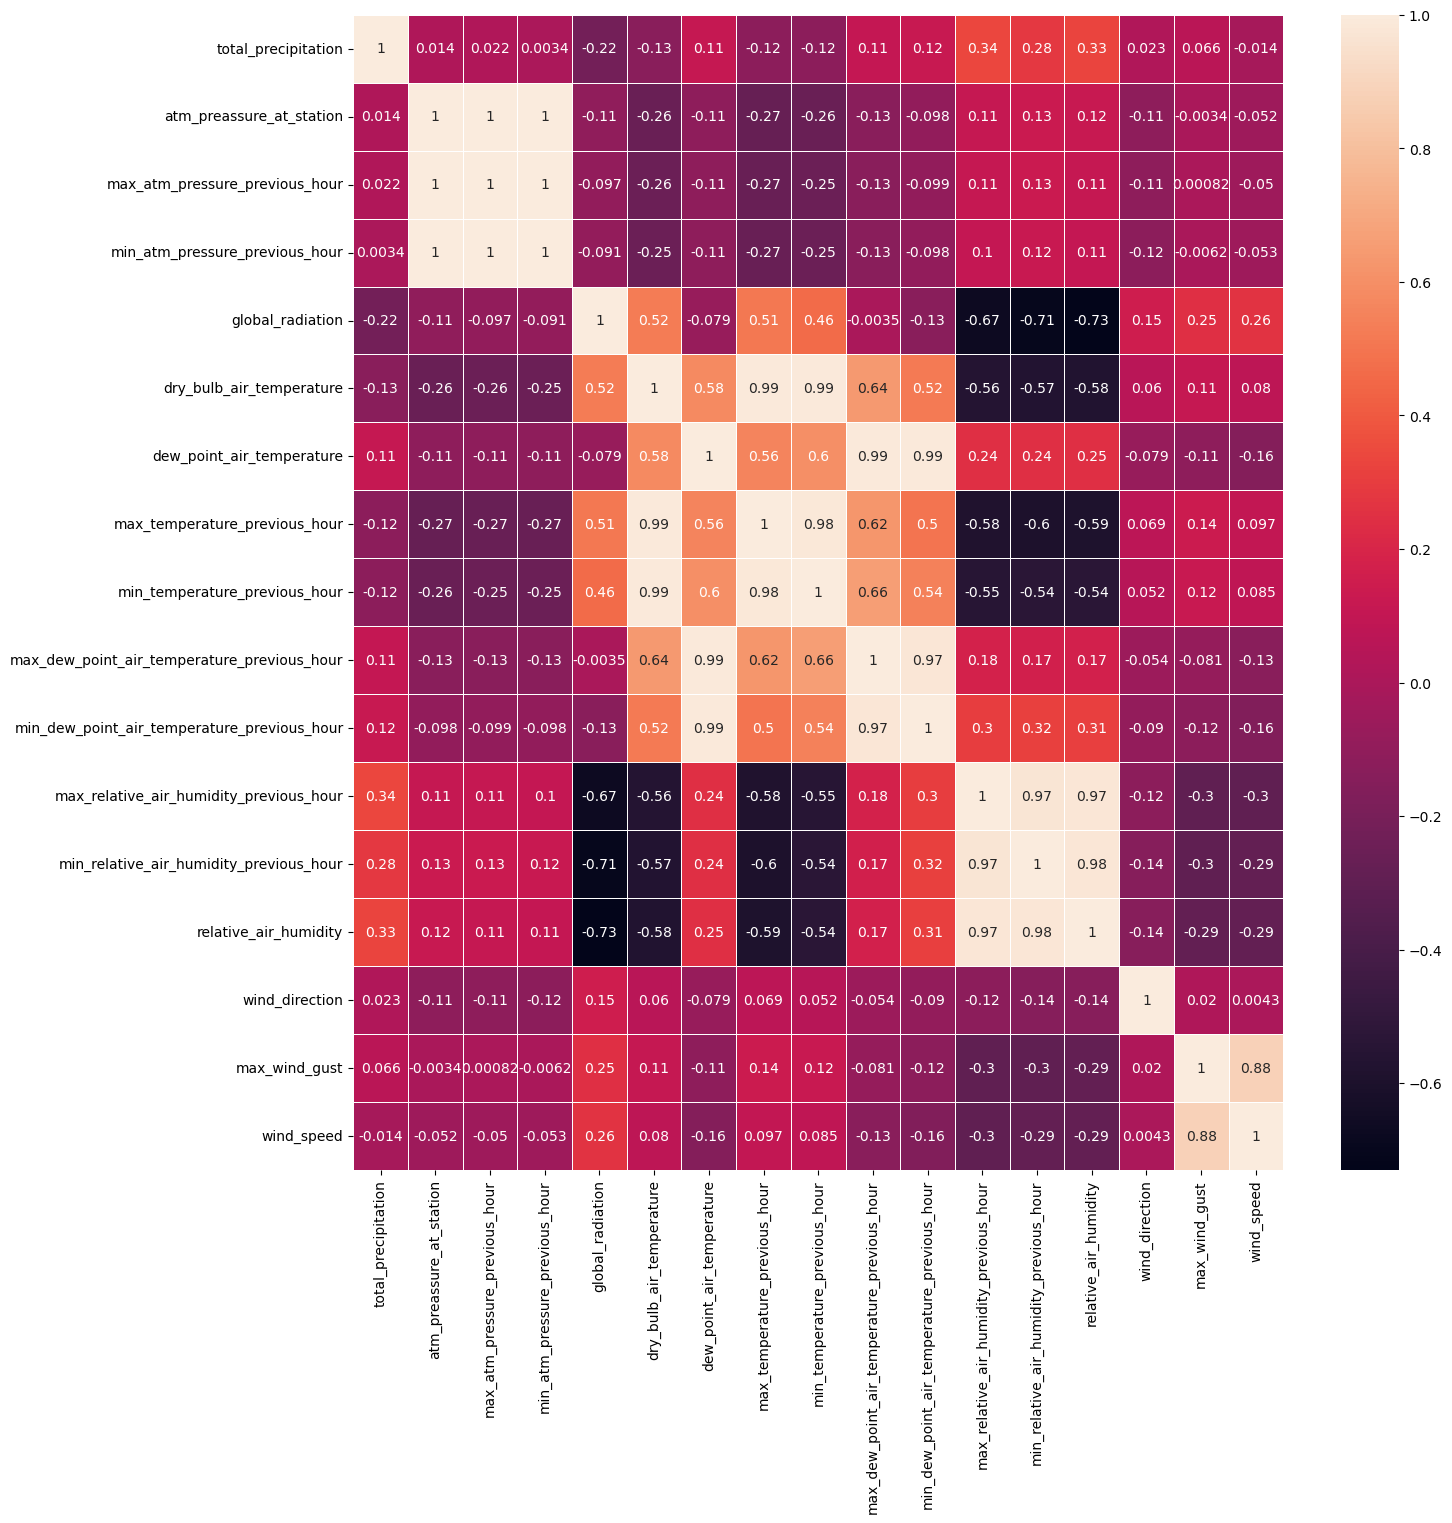

In [23]:
plt.figure(figsize=(15, 15))

sns.heatmap(
    data=south_weather_metrics_corr,
    annot=True,
    linewidth=.5
)

plt.show()

#### Resposta

A coluna que apresenta maior correlação com a coluna `wind_speed` é a coluna `max_wind_gust`, isto é, a maior rajada de vento metrificada está correlacionado com a velocidade do vento.\
Com uma correlação positiva de $0.88$, poderíamos remover uma destas colunas antes de realizarmos o treinamento de um modelo de aprendizado de máquina, uma vez que o somatório de informação obtido\
pelas duas, não traria maior vantagem significativa, além de que ao removermos uma destas colunas, obteriamos um ganho de performance no treinamento do modelo.

### 3) Redução de Dimensionalidade com PCA

**Questão**: Após aplicar PCA ao dataset numérico, os primeiros 6 componentes principais explicam que porcentagem da variância total dos dados? Discuta como a escolha do número de componentes pode impactar o equilíbrio entre a simplificação do modelo e a perda de informação.

**Objetivo:** Analisar a variância explicada por cada componente principal e tomar decisões sobre o número ideal de componentes para representar os dados, considerando a preservação da variabilidade original.

#### Resposta